In [1]:
# 데이터: https://finance.yahoo.com/quote/TSLA/history?period1=1436486400&period2=1594339200&interval=1d&filter=history&frequency=1d&guccounter=1&guce_referrer=aHR0cHM6Ly9pbnNpZ2h0Y2FtcHVzLmNvLmtyLw&guce_referrer_sig=AQAAAEdpdKfYVAH9tWB8jQ9CR2OmsSBdVYuYtyHW_IJZ8mvl_HVlrIQEkVA_-9fsbFu6zBUjoBG2vy_VSnuFrm24_Bf6rQpB9kkH4oWFJk1lvlmgOFVYtch2r7ZhlrD0XrHlA-GCXw-Okl9oBit7uoVAryQIcstmSHMpzwjloGu7FPFo

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt

from torch.utils.data.dataset import Dataset
from torch.optim.adam import Adam
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader

In [36]:
## 데이터셋 정의 및 클래스
data = pd.read_csv("./data/TSLA.csv")
# data.info()

class Stock(Dataset):
    def __init__(self):
        self.csv = data

        # 입력 데이터 정규화
        self.data = self.csv.iloc[:, 1:4].values   # 종가를 제외한 데이터
        self.data = self.data / np.max(self.data)  # 0과 1 사이로 min-max 정규화

        # 종가 데이터 min-max 정규화
        self.label = data["Close"].values         
        self.label = self.label / np.max(self.label)
        
    def __len__(self):
        return len(self.data) - 30 # 사용 가능한 배치 개수

    # 입력데이터와 종가 데이터를 30일치씩 읽어옵니다.
    def __getitem__(self, i):
        data = self.data[i:i+30]
        label = self.label[i+30]

        return data, label

In [37]:
## RNN 클래스
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size=3, hidden_size=8, num_layers=5, batch_first=True)

        # 주가를 예측하는 MLP층 정의
        self.fc1 = nn.Linear(in_features=240, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=1)

        self.relu = nn.ReLU()
        
    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)

        x = torch.reshape(x, (x.shape[0], -1)) # MLP층의 입력으로 사용될 수 있도록 모양 변경

        # MLP 층을 이용해 종가를 예측
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
      
        # 예측한 종가를 1차원 벡터로 표현
        x = torch.flatten(x)

        return x

In [38]:
## 모델과 데이터셋 정의
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = RNN().to(DEVICE)
dataset = Stock()
loader = DataLoader(dataset, batch_size=32)
#optim = Adam(params=model.parameters(), lr=0.0001)
optim = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [39]:
## 학습
EPOCH = 300
for epoch in range(EPOCH):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        h0 = torch.zeros(5, data.shape[0], 8).to(DEVICE) # 초기 은닉 상태

        pred = model(data.type(torch.FloatTensor).to(DEVICE), h0) # 모델의 예측값

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(DEVICE))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), "./rnn2.pt")

epoch86 loss:0.03335753455758095: 100%|████████████████████████| 7/7 [00:00<00:00, 25.09it/s]


epoch173 loss:0.03306586667895317: 100%|███████████████████████| 7/7 [00:01<00:00,  6.73it/s]


epoch260 loss:0.032849766314029694: 100%|██████████████████████| 7/7 [00:00<00:00, 39.50it/s]


epoch299 loss:0.0327465645968914: 100%|████████████████████████| 7/7 [00:00<00:00, 17.70it/s]


In [42]:
## 평가
loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn2.pt", map_location=DEVICE))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(DEVICE)

        pred = model(data.type(torch.FloatTensor).to(DEVICE), h0)
        preds.append(pred.item())
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(DEVICE))
        total_loss += loss/len(loader) # 손실의 평균치 계산

total_loss.item()

0.013599295169115067

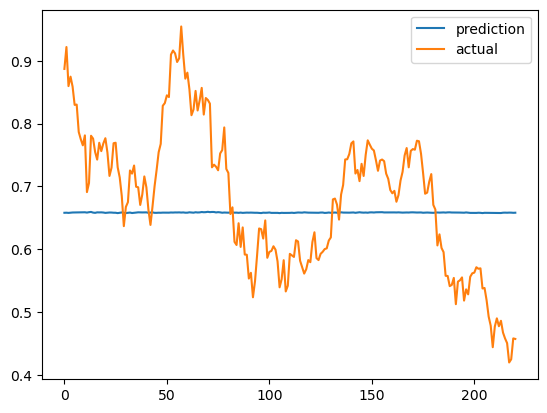

In [43]:
## 평가 결과 확인
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()

epoch49 loss:0.006181374192237854: 100%|██████████████████| 221/221 [00:01<00:00, 111.51it/s]


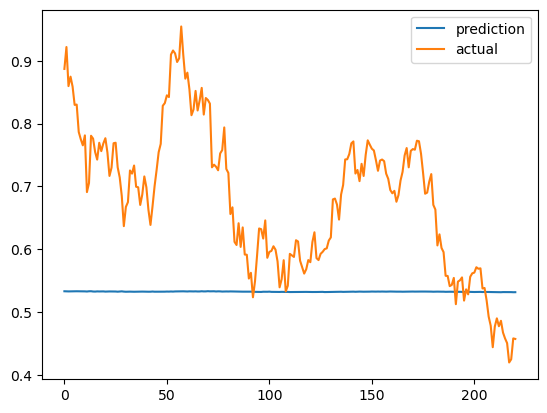

In [44]:
## 학습
EPOCH = 50
for epoch in range(EPOCH):
    iterator = tqdm.tqdm(loader)
    for data, label in iterator:
        optim.zero_grad()

        h0 = torch.zeros(5, data.shape[0], 8).to(DEVICE) # 초기 은닉 상태

        pred = model(data.type(torch.FloatTensor).to(DEVICE), h0) # 모델의 예측값

        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(DEVICE))
        loss.backward()
        optim.step()

        iterator.set_description(f"epoch{epoch} loss:{loss.item()}")
torch.save(model.state_dict(), "./rnn3.pt")

## 평가
loader = DataLoader(dataset, batch_size=1)  # 예측값을 위한 데이터 로더

preds = []  # 예측값들을 저장하는 리스트
total_loss = 0

with torch.no_grad():
    model.load_state_dict(torch.load("rnn3.pt", map_location=DEVICE))

    for data, label in loader:
        h0 = torch.zeros(5, data.shape[0], 8).to(DEVICE)

        pred = model(data.type(torch.FloatTensor).to(DEVICE), h0)
        preds.append(pred.item())
        loss = nn.MSELoss()(pred, label.type(torch.FloatTensor).to(DEVICE))
        total_loss += loss/len(loader) # 손실의 평균치 계산

total_loss.item()

## 평가 결과 확인
plt.plot(preds, label="prediction")
plt.plot(dataset.label[30:], label="actual")
plt.legend()
plt.show()